# Análisis de elasticidad de la probabilidad de compra para cada segmento

En esta ocasión vamos a utilizar el concepto de *elasticidad de precios* y un modelo de regresión lineal para estimar la probabilidad de compras de barras de chocolate, en promedio y por segmento, y también en el caso de que tengamos o no tengamos promoción en la compra.

In [1]:
### Librerías

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

### Preparando datos

Antes que nada, debemos preparar o *pre-procesasr* los datos según hemos trabajado anteriormente. La idea de esto es poder procesar los datos para poder segmentar los clientes en las cuatro categorías que hemos visto y utilizarlos para el análisis.

In [2]:
#Cargamos los datos crudos
df_compras = pd.read_csv("datasets/purchase_data.csv")
# df_compras.head()
# print(df_compras.columns)

# Cargamos el modelo de escalamiento o scaler que entrenamos anteriormente.
scaler = pickle.load(open('models/scaler.pickle', 'rb'))

#  Cargamos el modelo de PCA
pca = pickle.load(open('models/pca.pickle', 'rb'))

# Cargamos el modelo PCA
kmeans_pca = pickle.load(open('models/kmeans_pca.pickle', 'rb'))

In [3]:
## Aplicamos estandarización

features = df_compras[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_compras_std = scaler.transform(features)

# Aplicamos PCA a los datos estandarizados
df_compras_pca = pca.transform(df_compras_std)

# Segmentamos los datos usando el modelo de KMeans entrenado previamente
segmentos = kmeans_pca.predict(df_compras_pca)

# Creamos una copia del dataframe original para trabajar sin modificar los datos del set original.
df_compras_predictor = df_compras.copy()

# Agregamos labels
df_compras_predictor["Segmento"] = segmentos

segmentos_dummies = pd.get_dummies(segmentos, prefix = 'Segmento', prefix_sep = '_')
df_compras_predictor = pd.concat([df_compras_predictor, segmentos_dummies], axis = 1)

# df_compras_predictor.head()

Vamos a calcular la elasticidad de precios promedio para todos los segmentos como lo hicimos anteriormente. Luego compararemos con cada segmento para sacar conclusiones.

In [6]:
# Variable dependiente
Y = df_compras_predictor["Incidence"]

# Variable independiente
X = pd.DataFrame(df_compras_predictor[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"])
X.head()

lr_predictor = LogisticRegression(solver = "sag")
lr_predictor.fit(X,Y) #entrenamos el modelo

#Rango de precios para las 5 marcas
df_compras_predictor[df_compras_predictor["Incidence"]==1][['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

rango_precios = pd.DataFrame(np.arange(0.5, 3.5, 0.01), columns = ["precio"]).round(2)

probabilidades = lr_predictor.predict_proba(rango_precios)
proba_compra = probabilidades[:,1]

beta = lr_predictor.coef_[0][0] #beta
elasticidad_media = beta*rango_precios["precio"].values*(1 - proba_compra)

master_elasticidades = pd.DataFrame(rango_precios["precio"].values, columns = ["precio"]) #dataframe con los valores de elasticidad
master_elasticidades["elasticidad media"] = elasticidad_media
master_elasticidades

,precio,elasticidad media
0,0.50,-0.096462
1,0.51,-0.100533
2,0.52,-0.104731
3,0.53,-0.109059
4,0.54,-0.113521
...,...,...
295,3.45,-8.014066
296,3.46,-8.039317
297,3.47,-8.064533
298,3.48,-8.089715


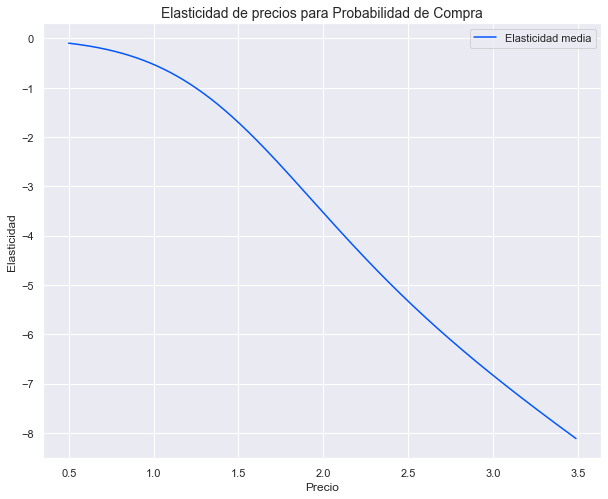

In [5]:
## Graficamos

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Elasticidad de precios para Probabilidad de Compra", fontsize = 14)
ax.set_xlabel("Precio")
ax.set_ylabel("Elasticidad")
ax.plot(master_elasticidades["precio"],master_elasticidades["elasticidad media"], color = "#0055ff",label = "Elasticidad media")
plt.legend()
plt.show()

## Segmento *Enfocados en trabajar* (segmento 1)

Realizaremos el análisis sobre el segmento 1, enfocados en trabajar. Para esto, debemos primeramente quedarnos con los datos correspondientes a este segmento y luego aplicar el mismo procedimiento que hemos aplicado para calcular la elasticidad de precios promedio.

In [6]:
#filtramos datos para el segmento 1
compras_segmento1 = df_compras_predictor[df_compras_predictor["Segmento"]==1] #nos quedamos con los datos del segmento 1

Y_s1 = compras_segmento1["Incidence"]
X_s1 = pd.DataFrame(compras_segmento1[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"])

In [7]:
#entrenamos modelo y predecimos en base al rango de precios
lr_predictor_s1 = LogisticRegression(solver = "sag") #predictor para segmento 1
lr_predictor_s1.fit(X_s1,Y_s1)

#estimo las probabilidades usando el modelo
probabilidades = lr_predictor_s1.predict_proba(rango_precios)
proba_compra_s1 = probabilidades[:,1] #proabilidades de compra para el segmento 1

In [8]:
#Calculamos los valores de elasticidad
beta_s1 = lr_predictor_s1.coef_[0][0] #beta
elasticidad_s1 = beta_s1*rango_precios["precio"].values*(1 - proba_compra_s1)

In [9]:
#Agrego los datos nuevos a mi dataframe maestro
master_elasticidades["pe_s1"] = elasticidad_s1 #em_s1 = elasticidad media para segmento 1 

## Segmento *Estandar* (segmento 0)

Realizamos el mismo procedimiento que hicimos para el segmento 1. Esta vez lo dejamos todo en la misma celda.

In [10]:
#filtramos datos para el segmento 0
compras_segmento0 = df_compras_predictor[df_compras_predictor["Segmento"] == 0] #nos quedamos con los datos del segmento 0

Y_s0 = compras_segmento0["Incidence"]
X_s0 = pd.DataFrame(compras_segmento0[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"])

#entrenamos modelo y predecimos en base al rango de precios
lr_predictor_s0 = LogisticRegression(solver = "sag") #predictor para segmento 0
lr_predictor_s0.fit(X_s0,Y_s0)

#estimo las probabilidades usando el modelo
probabilidades = lr_predictor_s0.predict_proba(rango_precios)
proba_compra_s0 = probabilidades[:,1] #proabilidades de compra para el segmento 0

#Calculamos los valores de elasticidad
beta_s0 = lr_predictor_s0.coef_[0][0] #beta
elasticidad_s0 = beta_s0*rango_precios["precio"].values*(1 - proba_compra_s0)

#Agrego los datos nuevos a mi dataframe maestro
master_elasticidades["pe_s0"] = elasticidad_s0 #em_s1 = elasticidad media para segmento 0 

## Segmento *Baja oportunidad* (segmento 2)

In [11]:
#filtramos datos para el segmento 0
compras_segmento2 = df_compras_predictor[df_compras_predictor["Segmento"] == 2] #nos quedamos con los datos del segmento 1

Y_s2 = compras_segmento2["Incidence"]
X_s2 = pd.DataFrame(compras_segmento2[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"])

#entrenamos modelo y predecimos en base al rango de precios
lr_predictor_s2 = LogisticRegression(solver = "sag") #predictor para segmento 2
lr_predictor_s2.fit(X_s2,Y_s2)

#estimo las probabilidades usando el modelo
probabilidades = lr_predictor_s2.predict_proba(rango_precios)
proba_compra_s2 = probabilidades[:,1] #proabilidades de compra para el segmento 2

#Calculamos los valores de elasticidad
beta_s2 = lr_predictor_s2.coef_[0][0] #beta
elasticidad_s2 = beta_s2*rango_precios["precio"].values*(1 - proba_compra_s2)

#Agrego los datos nuevos a mi dataframe maestro
master_elasticidades["pe_s2"] = elasticidad_s2 #em_s2 = elasticidad media para segmento 2 

## Segmento *Acomodados* (segmento 3)

In [12]:
#filtramos datos para el segmento 0
compras_segmento3 = df_compras_predictor[df_compras_predictor["Segmento"] == 3] #nos quedamos con los datos del segmento 1

Y_s3 = compras_segmento3["Incidence"]
X_s3 = pd.DataFrame(compras_segmento3[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"])

#entrenamos modelo y predecimos en base al rango de precios
lr_predictor_s3 = LogisticRegression(solver = "sag") #predictor para segmento 3
lr_predictor_s3.fit(X_s3,Y_s3)

#estimo las probabilidades usando el modelo
probabilidades = lr_predictor_s3.predict_proba(rango_precios)
proba_compra_s3 = probabilidades[:,1] #proabilidades de compra para el segmento 3

#Calculamos los valores de elasticidad
beta_s3 = lr_predictor_s3.coef_[0][0] #beta
elasticidad_s3 = beta_s3*rango_precios["precio"].values*(1 - proba_compra_s3)

#Agrego los datos nuevos a mi dataframe maestro
master_elasticidades["pe_s3"] = proba_compra_s3 #em_s3 = elasticidad media para segmento 3

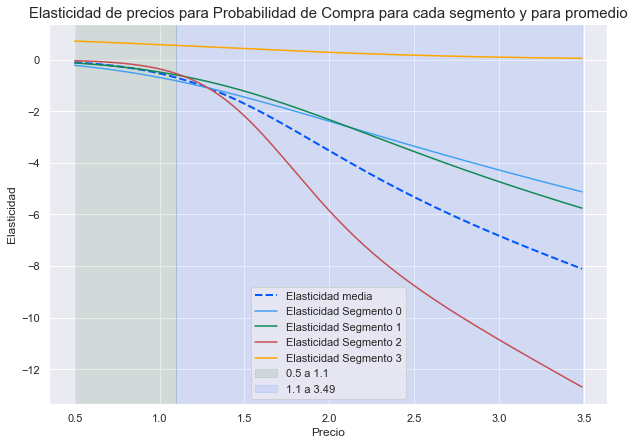

In [13]:
## Graficamos

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Elasticidad de precios para Probabilidad de Compra para cada segmento y para promedio", fontsize = 15)
ax.set_xlabel("Precio")
ax.set_ylabel("Elasticidad")
ax.plot(master_elasticidades["precio"],master_elasticidades["elasticidad media"], color = "#0055ff",
            label = "Elasticidad media", linewidth = 2, linestyle = "--")
ax.plot(master_elasticidades["precio"],master_elasticidades["pe_s0"], color = "#44a2f2",label = "Elasticidad Segmento 0")
ax.plot(master_elasticidades["precio"],master_elasticidades["pe_s1"], color = "#118852",label = "Elasticidad Segmento 1")
ax.plot(master_elasticidades["precio"],master_elasticidades["pe_s2"], color = "r",label = "Elasticidad Segmento 2")
ax.plot(master_elasticidades["precio"],master_elasticidades["pe_s3"], color = "orange",label = "Elasticidad Segmento 3")

#superficies
ax.axvspan(0.5, 1.1, color = "#005500", alpha=0.1, label = "0.5 a 1.1")
ax.axvspan(1.1, 3.49, color = "#0055ff", alpha=0.1, label = "1.1 a 3.49")

plt.legend()
plt.show()

## Analizando gráficos

Todos los segmentos, excpeto el segmento 3 (acomodados) poseen valores negativos de elasticidad. Ahora bien, los segmentos 0, 1 y 2 poseen en el rango de 0.5USD a 1.1USD valores similares de elasticidad.

Sin ebargo, el segmento 2 (baja oportunidad) decae mucho más rapido que el resto, sobre todo comparandolo con el segmento de acomodados. Podemos decir que el segmento de baja oportunidad es *sensible a los cambios de precio*.

Debemos notar que el segmento de baja oportunidades posee en el rango de 0.5USD y un poco mas de 1.1USD esta por encima de la media. Esto nos indica que este segmento es algo más inelástico que el resto. Pero se hace muy elástico para precios altos. ¿Por qué pasa esto? Como primera razón podemos decir que el efecto visto es debido a cuestiones *técnicas*, en el sentido de que este segmento es el más grande y esto podría llevar a que el segmento deba ser estudiado con más detalle. Otra razón puede ser que este segmento disfruta mucho de comer barras de chocolate y por lo tanto, subir el precio en el rango de precios bajos no genera un cambio drástico en la probabilidad de compra, pero cuando el precio aumenta por encima de cierto valor, el segmento dejará rápidamente de comprar barra de chocolates. Según nuestro análisis realizado (ver heatmap en archivo *analizando compras*) vimos que este segmento era muy reacio a comprar marcas caras (tenía una fuerte inclinación por la marca 1). 

# Proabilidad de compra con promoción

A continuación realizaremos el mismo análisis que antes pero esta vez agregando la columna de promociones como una nueva feature.

Veamos.

In [14]:
Y = df_compras_predictor["Incidence"] #variable dependiente

#Variable independiente
X = pd.DataFrame(df_compras_predictor[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"]) #media de precios
X["promo"] = df_compras_predictor[['Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4','Promotion_5']].mean(axis  = 1) 

In [15]:
lr_predictor_con_promo = LogisticRegression(solver = "sag")
lr_predictor_con_promo.fit(X,Y)
lr_predictor_con_promo.coef_

array([[-1.49398822,  0.56153162]])

Podemos ver que,

- El coeficiente para precios es de -1.49 lo cual indica, como vimos antes, que el aumento de precio dará una baja en la probabilidad de compra.
- El coeficiente para promociones es de 0.561, que a diferencia del punto anterior, una mejora en la promoción implicará un aumento en la probabilidad de compra (como es de esperarse).

Vamos a realizar el cálculo de dos elasticidades, uno considerando como que las ventas tienen una promoción y otro considerando ninguna promoción. Además, utilizaremos el mismo rango de precios que hemos creado anteriormente.

#### Elasticidad con promoción

In [16]:
df_precios_promociones = pd.DataFrame(rango_precios)
df_precios_promociones["promo"] = 1

#obteniendo probabilidades
probabilidades = lr_predictor_con_promo.predict_proba(df_precios_promociones)
proba_compra_con_promo = probabilidades[:,1]

#beta
beta_promo = lr_predictor_con_promo.coef_[:,0]
#calculamos la elasticidad
# elasticidad_precio_promo = 

beta_promo = lr_predictor_con_promo.coef_[:,0]

elasticidad_con_promo = beta_promo*rango_precios["precio"].values*(1 - proba_compra_con_promo)
# elasticidad_con_promo

#actualizamos dataframe maestro
master_elasticidades["pe_con_promo"] = elasticidad_con_promo


#### Elasticidad sin promoción

In [17]:
df_precios_sin_promociones = pd.DataFrame(rango_precios)
df_precios_sin_promociones["promo"] = 0

#obteniendo probabilidades
probabilidades = lr_predictor_con_promo.predict_proba(df_precios_sin_promociones)
proba_compra_sin_promo = probabilidades[:,1]

#beta
beta_promo = lr_predictor_con_promo.coef_[:,0]
#calculamos la elasticidad
# elasticidad_precio_promo = 

beta_promo = lr_predictor_con_promo.coef_[:,0]

elasticidad_sin_promo = beta_promo*rango_precios["precio"].values*(1 - proba_compra_sin_promo)
# elasticidad_sin_promo

#actualizamos dataframe maestro
master_elasticidades["pe_sin_promo"] = elasticidad_sin_promo
# master_elasticidades.head()


### Grafico de elasticidad en la probabilidad de compra para promoción y sin promoción

*Importate:* LAs dos graficas que vemos representan la elasticidad en la probabilidad de compra cuando tenemos un máximo en promociones y un mínimo de promociones.

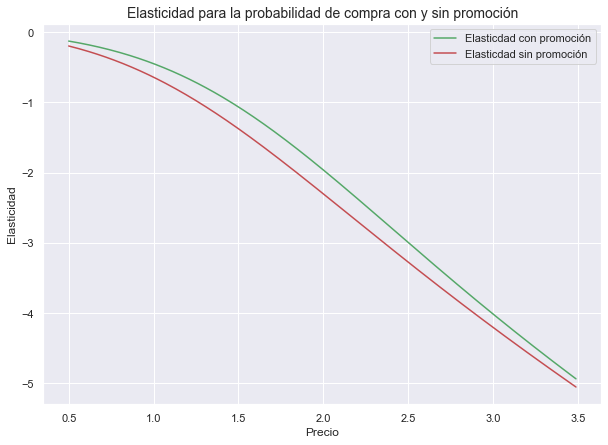

In [20]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Elasticidad para la probabilidad de compra con y sin promoción", fontsize = 14)
ax.set_xlabel("Precio")
ax.set_ylabel("Elasticidad")
ax.plot(master_elasticidades["precio"],master_elasticidades["pe_con_promo"], label = "Elasticdad con promoción", color = "g")
ax.plot(master_elasticidades["precio"],master_elasticidades["pe_sin_promo"], label = "Elasticdad sin promoción", color = "r")
plt.legend()

plt.show()

In [38]:
print(master_elasticidades[np.abs(master_elasticidades["pe_con_promo"]) < 1][["precio","pe_con_promo"]].iloc[-1])
print("")
print(master_elasticidades[np.abs(master_elasticidades["pe_sin_promo"]) < 1][["precio","pe_sin_promo"]].iloc[-1])

precio          1.450000
pe_con_promo   -0.986918
Name: 95, dtype: float64

precio          1.260000
pe_sin_promo   -0.988013
Name: 76, dtype: float64


#### Comentarios sobre gráfico de elasticidad con y sin promoción

- Podemos ver que para todo el rango de precios, la elasticidad en la probabilidad de compra es mayor para los productos con promoción.
- En la celda anterior hemos impreso los precios en el cual las curvas pasan de ser inelásticos a elásticos. En el caso de la elasticidad sin promoción el precio es de 1.26USD, mientras que para la elasticidad con promoción el precio es de 1.45USD. Entonces, supongamos que estamos sobre la curva de elasticidad sin promoción (roja) y el precio de la barra de chocolate es de 1.3USD, en este caso, estaremos en la región elástica. Ahora bien, supongamos que estamos sobre la curva de elasticidad con promoción (verde), si el precio es de 1.5USD y nos movemos al precio de 1.3USD, estaremos en la zona inelástica! Esto es importante ya que **evidentemente las personas están dispuetas a comprar más productos con promoción**. Tal vez debido a una cuestión psicoloógica, ver los descuentos puede resultar atractivo o bien porque la gente piensa que esta haciendo un buen negocio. En cualquier caso, **los clientes son menos sensibles a cambios de precios sobre productos con promoción**. Esto nos deja con la siguiente observación, *es mejor tener precios caros con constante promociones* a tener *productos con precios baratos de entrada*.